## Simple backpropagation neural network
This is an attempt to solve Kaggle MNIST competition with multilayer neural network. I'm writing a NN myself so that I can get a gist of how they work and whats the features of constructing such networks.

#### Class Neuron
This is just one neuron, it has weights of inputs and an output, it can calculate output for given vector of input values (i.e. spike) and it can learn (adjust weights according to given error rate sigma). There is also a setter for a learning rate alpha which can be helpful in some situations.

In [1]:
import numpy as np
from scipy.misc import derivative

class Neuron:
    def __init__(self, in_size, alpha):
        self.weights = np.random.uniform(low = -0.1, high = 0.1, size = in_size + 1)
        self.alpha = alpha
        self.out = 0
        
    def setLearnRate(self, newalpha):
        self.alpha = newalpha
        
    def actvF(self, s):
        return 1/(1 + np.exp(-s))
        
    def spike(self, sample):
        s = sum(self.weights * np.append(sample, 1))
        self.out = self.actvF(s)
        return self.out
        
    def learn(self, sample, sigma, nxt_wt = None):
        sample = np.append(sample, 1)
        if nxt_wt is None:
            # this is a neuron of the last layer, passing sigma unchanged
            for i, e in enumerate(self.weights):
                self.weights[i] -= self.alpha * sigma * sample[i]
        else:
            # this one isn't in the last layer, so need to recalculate error (sigma) and pass it further
            for i, e in enumerate(self.weights):
                self.weights[i] -= self.alpha * sum(sigma * nxt_wt) * self.out * (1 - self.out) * sample[i]
            sigma = sum(sigma * nxt_wt) * derivative(self.actvF, sum(self.weights * sample))
        return sigma
            

#### Class NLayer
NLayer is a one layer of neurons and is sort of a wrapper for neurons array. To create a neuron layer you need to specify the size of its input vector, a number of neurons, their initial learning rate and the following layer. Unlike Neuron class, NLayer stores an input value which can be set with setInput function. This class also has a setLearnRate function that calls the corresponding function for each neuron.

For calculating an output there are two functions, process and process_mt, they are doing basically the same thing (which is just calling spike fucntion for each neuron) but process_mt is trying to do so in a parallel and sort of a map-reduce manner. It works much slower though and I do recommend to ignore this method.

In [2]:
import threading

class NLayer:
    def __init__(self, in_size, n_neurons, alpha, nxt = None):
        self.in_size = in_size
        self.n_neurons = n_neurons
        self.neurons = np.empty(n_neurons, dtype = object)
        for i in range(self.n_neurons):
            self.neurons[i] = Neuron(in_size, alpha)
        self.nxt = nxt
        
    def setLearnRate(self, newalpha):
        for neuron in self.neurons:
            neuron.setLearnRate(newalpha)
            
    def setInput(self, sample):
        self.in_signal = sample
        
    def process(self, neurons = None): 
        if neurons == None:
            neurons = self.neurons
            self.output = np.empty(self.n_neurons)
            for i in range(len(neurons)):
                self.output[i] = neurons[i].spike(self.in_signal)
            
    def process_mt(self, nproc):
        self.output = []
        neuron_chunks = np.array_split(self.neurons, nproc)
        treads = []
        for i in range(nproc):
            treads.append(threading.Thread(target = self.process, args = (neuron_chunks[i],)))
        for t in treads:
            t.start()
            t.join()
        self.output = np.array(self.output)
            
    def learn(self, sigmas):
        if not self.nxt:
            # this is the last layer
            for k in range(self.n_neurons):
                self.neurons[k].learn(self.in_signal, sigmas[k])
            return sigmas
        else:
            self.sigmas = np.zeros(self.n_neurons)
            for k in range(self.n_neurons):
                nxt_wt = np.zeros(self.nxt.n_neurons)
                for i in range(self.nxt.n_neurons):
                    nxt_wt[i] = self.nxt.neurons[i].weights[k]
                self.sigmas[k] = self.neurons[k].learn(self.in_signal, sigmas, nxt_wt)
            return self.sigmas
                

#### Class NNetwork
This is another wrapper but for layers now. To create a network one need to specify size of an input vector, size of a desired output, a list containing numbers of neurons for hidden layers and an initial learning rate. When created, it creates and arranges layers of specified sizes. Process function has an argument npoc which is for parallel processing and is not suggested as I said it a description of a layer class.

In [3]:
class NNetwork:    
    def __init__(self, in_size, out_size, hiddlist, alpha = 0.01):
        self.layers = np.empty(len(hiddlist) + 1, dtype = object)
        self.layers[-1] = NLayer(hiddlist[-1], out_size, alpha)
        for i in range(1, len(hiddlist))[::-1]:
            self.layers[i] = NLayer(hiddlist[i-1], hiddlist[i], alpha, nxt = self.layers[i+1])
        self.layers[0] = NLayer(in_size, hiddlist[0], alpha, nxt = self.layers[1])
        
    def setLearnRate(self, newalpha):
        for layer in self.layers:
            layer.setLearnRate(newalpha)
        
    def printLayers(self):
        for i, l in enumerate(self.layers):
            print(l.in_size, l.n_neurons, l.nxt)
            
    def process(self, sample, nproc = None):
        for i in range(len(self.layers)):
            if i == 0:
                self.layers[i].setInput(sample)
            else:
                self.layers[i].setInput(self.layers[i-1].output)
            if nproc == None:
                self.layers[i].process()
            else:
                self.layers[i].process_mt(nproc)
            
        self.answer = self.layers[-1].output
        return self.answer
        
    def learn(self, d):
        sigmas = np.empty(len(d))
        for i in range(len(d)):
            sigmas[i] = (self.layers[-1].neurons[i].out - d[i]) * self.layers[-1].neurons[i].out * (1 - self.layers[-1].neurons[i].out)
            
        for i in range(len(self.layers))[::-1]:
            sigmas = self.layers[i].learn(sigmas)

This is small functions made for the purposes of digit recognition. labelToArray transforms digit in a binary format and arrayToLabel is doing the opposite.

In [4]:
def labelToArray(data):
    binstring = "{0:b}".format(data)
    missing = (4 - len(binstring)) * '0'
    return [int(s) for s in missing + binstring]

def arrayToLabel(arr):
    arr = [int(round(x)) for x in arr]
    s = ''.join(map(str, arr))
    return int(s, 2)

#### So let's give it a try!
In here we're just reading a part of MNIST handwritten digits down and splitting'em into test and training datasets.

In [5]:
from pandas import read_csv
from sklearn.cross_validation import train_test_split

rawtrain = read_csv('train.csv', nrows=10000).values

X_train, X_test, y_train, y_test = train_test_split(rawtrain[:, 1:], rawtrain[:, 0], test_size = 0.33, random_state = 42)

And reducing dimensionality with PCA

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

Now let's create a neural network with an input size equals to the number of variables in our training data, output of size 4 (since we only have digits from 0 to 9 and need 4 bits to represent them binarily) and one hidden layer of size 100. Not too complex :)

In [7]:
np.random.seed(42)
net = NNetwork(X_train_pca.shape[1], 4, [100])

And now it's time to learn this network. We are going to make it in 5 epochs with decresing learning rate. And we'll measure the time of execution as well.

In [8]:
import pyprind
from datetime import datetime

learnrate = 0.02
net.setLearnRate(learnrate)

nEpochs = 5
start = datetime.now()

for epoch in range(nEpochs):
    print('Epoch ' + str(epoch + 1))
    for i in pyprind.prog_bar(range(len(y_train)), stream = 1, width = 70):
        answer = labelToArray(y_train[i])
        net.process(X_train_pca[i])
        net.learn(answer)
    learnrate /= 2
    net.setLearnRate(learnrate)
        
overalltime = datetime.now() - start
print('Overall time:', overalltime)

Epoch 1
0%                                                                  100%
[######################################################################] | ETA[sec]: 0.000 
Total time elapsed: 756.247 sec
Epoch 2
0%                                                                  100%
[######################################################################] | ETA[sec]: 0.000 
Total time elapsed: 753.861 sec
Epoch 3
0%                                                                  100%
[######################################################################] | ETA[sec]: 0.000 
Total time elapsed: 736.626 sec
Epoch 4
0%                                                                  100%
[######################################################################] | ETA[sec]: 0.000 
Total time elapsed: 720.122 sec
Epoch 5
0%                                                                  100%
[######################################################################] | ETA[sec]: 0.000 
Total t

#### What's the accuracy?

In [9]:
answers = np.empty(len(y_test))
X_test_pca = pca.transform(X_test)
for i in range(len(y_test)):
    ans = net.process(X_test_pca[i])
    if y_test[i] == arrayToLabel(ans):
        answers[i] = True
    else:
        answers[i] = False
        
print(round(sum(answers) / len(y_test) * 100, 3), '%')

68.97 %


I hope it turned out to be more than 10% which is just an accuracy of random guessing.

To check networks performance in a bit more detailed fashion we can look at a random observation form a test set and examine an overall apperance of the digit and a raw output of our network.

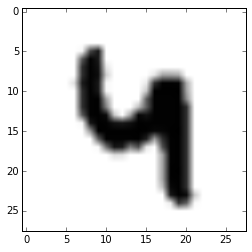

Actual label: 4
NN raw output: [ 0.26133157  0.81609907  0.37799165  0.41461725]
NN labeled output: 4


In [12]:
import matplotlib.pyplot as plt
n = np.random.randint(0, len(y_test))

sample = X_test[n]
sample = np.reshape(sample, (28, 28))

%matplotlib inline
plot = plt.imshow(sample)
plot.set_cmap('gray_r')
plt.show()

print('Actual label:', y_test[n])
a = net.process(X_test_pca[n])
print('NN raw output:', a)
print('NN labeled output:', arrayToLabel(a))